In [173]:
import pandas as pd
import numpy as np
import treelite
import pickle
import cudf
from sklearn.metrics import accuracy_score, classification_report

In [174]:
# Load the model
checkpoint_path = './pickled/cuml_model.tl'
tl_model = treelite.Model.deserialize(checkpoint_path)

cuml_model = pickle.load(open('./pickled/cuml_model.pkl', 'rb'))
scaler = pickle.load(open('./pickled/scaler.pkl', 'rb'))

In [175]:
# Load the data csv
df = pd.read_csv('./test_data/processed_test_data_22_05.csv', sep=' ')

In [176]:
TIME_COL = '1 MILLISEC'

def format_ms(t: str) -> int:
    m, s = t.split(':')
    return (int(m) * 60 + int(s)) * 1000

# Annotations for test_data_22_05
annotations = [
    ("0:00", "0:45", 1),# first 45000 ms -> standing
    ("0:45", "1:44", 2),# next 0:45 to 1:44  -> walking
    ("1:44", "2:36", 1),# from 1:44 to 2:36 -> standing
    ("3:21", "3:42", 4),# from 3:21 to 3:42 -> sitting
    ("3:43", "4:20", 1),# from 3:43 to 4:20 -> standing
    ("4:21", "4:38", 4),# from 4:21 to 4:38 -> sitting
    ("5:23", "5:50", 4),# 5:23 to 5:50 -> sitting
    ("5:50", "6:10", 1),# 5:50 to 6:10 -> standing
    ("6:10", "6:40", 4),# 6:10 to 6:40 -> sitting
    ("6:52", "7:20", 2),# 6:52 to 7:20 -> walking
    ("7:34", "8:00", 5),# 7:34 to 8:00 -> lying down
    ("8:26", "9:40", 2),# 8:26 to 9:40 -> walking
    ("9:40", "10:08", 1),# 9:40 to 10:08 -> standing
    ("10:15", "11:35", 5),# 10:15 to 11:35 -> lying down
    ("11:40", "11:50", 1),# 11:40 to 11:50 -> standing
    ("11:59", "12:40", 4),# 11:59 to 12:40 -> sitting
    ("14:40", "15:20", 1)# 14:40 to 15:20 -> standing
]

# Convert time strings to milliseconds
annotations = [(format_ms(start) + 50000, format_ms(end) + 50000, label) for start, end, label in annotations]

# Add a label column to the DataFrame and initialize with zeros
df['251 Label'] = 0

# Apply the labels based on the annotations
for start, end, label in annotations:
    df.loc[(df[TIME_COL] >= start) & (df[TIME_COL] <= end), '251 Label'] = label

# now drop the rows with 0
df = df[df['251 Label'] != 0]

# Label: all standing
# y_val = np.full(x_val.shape[0], 1)

In [177]:
# Preprocess the data
columns = [4,5,6, 7,8,9, 10,11,12, 13,14,15, 16,17,18,  22,23,24, 37,38,39,43,44,45, 56,57,58,  84,85,86, 97]

# Convert columns in dataset from names to indices
df.columns = [int(x.split()[0]) - 1 for x in df.columns]

# Drop the columns with NaN values
df = df.dropna(axis=0, subset=columns)
x_val = df.loc[:, columns]

y_val = np.array(df[250])

# Scale the data
x_val = scaler.transform(x_val)

## cuML prediction

In [178]:
# Run the model
y_pred = cuml_model.predict(cudf.DataFrame(data=x_val)).to_numpy()

# Evaluate the model performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_val, y_pred))

Accuracy: 0.28
              precision    recall  f1-score   support

           1       0.35      0.81      0.49       160
           2       0.50      0.02      0.03       128
           4       0.00      0.00      0.00       110
           5       0.05      0.06      0.05        84

    accuracy                           0.28       482
   macro avg       0.22      0.22      0.14       482
weighted avg       0.26      0.28      0.18       482



/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

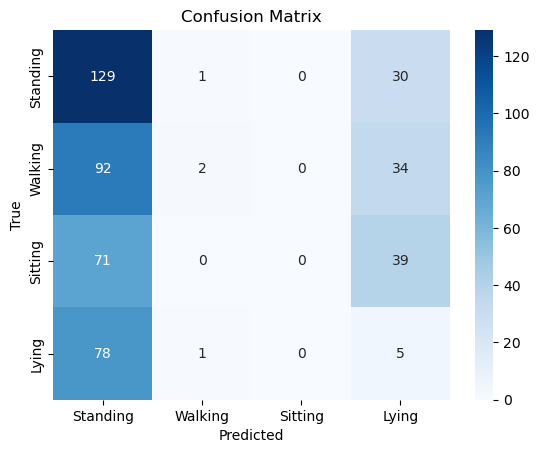

In [179]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

labels = [1, 2, 4, 5]
label_names = ['Standing', 'Walking', 'Sitting', 'Lying']

cm = confusion_matrix(y_val, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Treelite prediction

In [180]:
# Run the model
y_pred = treelite.gtil.predict(tl_model, x_val)

# Get the class with the highest probability
y_pred = np.argmax(y_pred[:, 0], axis=1)

# Map the indices to the labels
labels = [1, 2, 4, 5]
y_pred = [labels[i] for i in y_pred]

# Evaluate the model performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_val, y_pred))

Accuracy: 0.28
              precision    recall  f1-score   support

           1       0.35      0.81      0.49       160
           2       0.50      0.02      0.03       128
           4       0.00      0.00      0.00       110
           5       0.05      0.06      0.05        84

    accuracy                           0.28       482
   macro avg       0.22      0.22      0.14       482
weighted avg       0.26      0.28      0.18       482



/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mohamed/micromamba/envs/rapids-24.04/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif